# Дерево решений своими руками

####  Теорию брал тут: https://habr.com/ru/post/171759/

Про индекс Джини много источников, ну пусть будет этот видос: https://www.youtube.com/watch?v=2lEcfRuHFV4

Реализация прохода по дереву аналогична этой реализации: https://habr.com/ru/company/ods/blog/322534/

## Формальная задача:

1) Write a code in pure python (Numpy and Scipy are allowed, do not use scikit) able to create a decision tree. In input, you should provide the independent features and the dependent feature (the class) separately.
You can assume the dependent features and the independent feature binary. Please implements the Gini index and the entropy gain ratio. You can read the code available online, but you cannot plagiarize it. +

2) Create a toy example to run and test your code (please show the result). +



In [2]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize, scale
from sklearn import decomposition
import numpy as np

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt

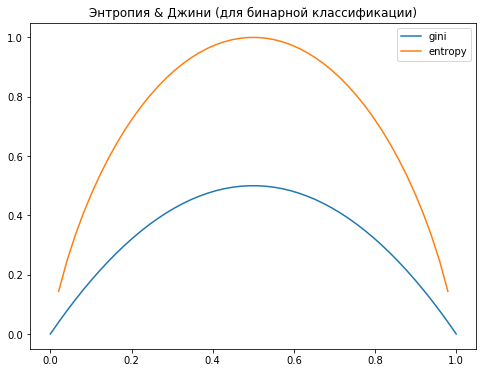

In [3]:
plt.rcParams['figure.figsize'] = (8,6)
xx = np.linspace(0,1,50)
plt.plot(xx, [2 * x * (1-x) for x in xx], label='gini')
plt.plot(xx, [-x * np.log2(x) - (1-x) * np.log2(1 - x)  for x in xx], label='entropy')
plt.title('Энтропия & Джини (для бинарной классификации)')
plt.legend();

In [9]:
def take_entropy(y): # находим энтропию системы
    
    n_examples = len(y)
    classes = np.unique(y)
    n_classes = len(classes)
    s = 0
    for x in classes:
        p = (y == x).sum()/n_examples
        s -= p*np.log(p) 
        
    return s

def take_igini(y): # находим индекс Джинни системы
    
    n_examples = len(y)
    classes = np.unique(y)
    n_classes = len(classes)
    g = 1
    for x in classes:
        p = (y == x).sum()/n_examples
        g -= p*p
        
    return g

def split_x(X, y, feature_number, criterion): # деление данных на 2 части по фиче и её значению
    
    Xl = []
    Xr = []
    yl = []
    yr = []
    i = 0
    for element in X:
        if element[feature_number] <= criterion:   # Xl - меньше критерия, Xr - больше критерия
            Xl.append(element)
            yl.append(y[i])
        else:
            Xr.append(element)
            yr.append(y[i])
        i += 1
    Xl = np.array(Xl)
    Xr = np.array(Xr)
    yl = np.array(yl)
    yr = np.array(yr)   
    
    return Xl, Xr, yl, yr

def find_best_criterion(X, y, use_gini = False): # выбираем лучшее разбиение
                                                # (находим фичу и ее значение, по которой будем разделять)
    
    n_features = X.shape[1]
    n_examples = len(y)
    classes = np.unique(y)
    n_classes = len(classes)
    
    IG = np.zeros((n_features,n_examples)) # мутим матрицу n_examples*n_features. В каждой ячейке число - прирост информации (IG)
    if use_gini:
        s0 = take_igini(y)
    else:
        s0 = take_entropy(y)
    
    for i in range(n_features):
        for j in range(n_examples):
            Xl, Xr, yl, yr = split_x(X, y, i, X[j,i])
            
            if use_gini:
                sl = take_igini(yl)
                sr = take_igini(yr)
            else:
                sl = take_entropy(yl)
                sr = take_entropy(yr)
            
            kl = len(yl)/n_examples
            kr = len(yr)/n_examples
            IG[i,j] = s0 - kl*sl - kr*sr # information gain(IG)/прирост информации
    
    i,j = np.unravel_index(IG.argmax(), IG.shape) # берем максимальный прирост. Запоминаем его индексы
    feature_number = i
    criterion = X[j,i]

    return feature_number, criterion

In [10]:
class Tree():
    '''
    Основан на рекурсивных
    вызовах, когда прописываются условия выхода из рекурсии. 
    '''
    def __init__(self):
              
        self.idx_feature = -1 # номер лучшего признака
        self.criter = 0 # значение лучшего признака
        self.value = None # класс, которому относится сампл, он же значение в листе
        self.left = None # левый потомок
        self.right = None # правый потомок
        
    def tree_fit(self, X, y, use_gini = False):
    
        n_features = X.shape[1]
        n_examples = len(y)
        classes = np.unique(y)
        n_classes = len(classes)
        
        if use_gini:
            entropy = take_igini(y)
        else:
            entropy = take_entropy(y)
        
        if entropy < 0.2: # если == 0, то получаем переобучение. Дерево строится, пока в каждом загоне останутся только
                                                        # примеры одного класса (получаем тупое запоминание всех самплов)
            unique, counts = np.unique(y, return_counts=True)
            self.value = dict(zip(unique, counts/len(y))) # Сохраняем словарь вероятностей каждого класса в качестве листа дерева
            #self.value = ... # тут можно играться. Например, выводить только класс, у которого вероятность больше или др.
        else:
            n, feat = find_best_criterion(X,y) #нашли лучшее разбиение
            X1, X2, y1, y2 = split_x(X, y, n, feat) #разбили по найденному лучшему разбиению
        
            self.idx_feature = n # номер фичи, по которой мы разделили
            self.criter = feat # значение, по которому мы разделили        
            self.left = Tree() # инициализируем потомков - такие же деревья решений
            self.right = Tree() # инициализируем потомков - такие же деревья решений
             
            self.left.tree_fit(X1, y1, use_gini = False)  # обучаем потомков
            self.right.tree_fit(X2, y2, use_gini = False) # обучаем потомков  
    
    def predict(self, sample):
        
        '''
        Функция для генерирования предсказания - смотрим узлы, идем 
        в соответствующих  потомков и смотрим в конце self.value - это
        и будет ответом.
        '''
        if self.idx_feature == -1:
            return self.value
        
        if sample[self.idx_feature] <= self.criter:
            return self.left.predict(sample)
        else:
            return self.right.predict(sample)

### Примеры использования:

In [11]:
# Простой датасет про 20 шариков на каждой координате. Предсказываем цвет шарика по координате. https://habr.com/ru/post/171759/
# Датасет (1 фича - координата, 2 класса)
X = np.array([i for i in range(20)]).reshape(20,1)
y = np.array([1,0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1,1,1,0])

In [2]:
iris = load_iris()
print(iris.data.shape, '\n')
print(iris.target)
iris.data[:5]

(150, 4) 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [12]:
first_tree = Tree()
first_tree.tree_fit(X, y)
print(first_tree.predict(np.array([[2]]))) # верно. Класс: вероятность этого класса. Если не сомневается, то вероятность = 1.0

{0: 1.0}


In [13]:
# ну и проверим на нашем любимом датасете iris (4 фичи, 3 класса)
second_tree = Tree()
second_tree.tree_fit(iris.data, iris.target)
print(second_tree.predict(iris.data[128])) # верно. Класс: вероятность принадлежности сампла к этому классу. 
        #Если сомневается, то будут перечислены все классы, к которым можно было бы отнести данный сампл + вер-ти этих классов

{1: 0.021739130434782608, 2: 0.9782608695652174}


In [14]:
first_tree = Tree()
first_tree.tree_fit(X, y, use_gini = True)
print(first_tree.predict(np.array([[18]]))) # верно. Класс: вероятность этого класса. Если не сомневается, то вероятность = 1.0

{1: 1.0}


In [15]:
# ну и проверим на нашем любимом датасете iris (4 фичи, 3 класса)
second_tree = Tree()
second_tree.tree_fit(iris.data, iris.target, use_gini = True)
print(second_tree.predict(iris.data[50])) # верно. Класс: вероятность принадлежности сампла к этому классу. 
        #Если сомневается, то будут перечислены все классы, к которым можно было бы отнести данный сампл + вер-ти этих классов

{1: 0.9791666666666666, 2: 0.020833333333333332}


Спасибо за просмотр. Надеюсь, код был легок для понимания. С уважением, Laggg (https://www.kaggle.com/laggg5)